In [1]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init

import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(2022)

if device == 'cuda':
  torch.cuda.manual_seed_all(2022)

In [3]:
def training_model(model, data, epochs):
  total_batch = len(data)

  for epoch in range(epochs):
    avg_cost = 0
    for X,Y in data:
      X = X.to(device)
      Y = Y.to(device)

      optimizer.zero_grad()
      hypothesis = model(X)
      cost = criterion(hypothesis, Y)
      cost.backward()
      optimizer.step()

      avg_cost += cost / total_batch

    print('[Eporch: {:>4} cost = {:>.9}'.format(epoch + 1, avg_cost))


In [ ]:
fashion_trainset = dsets.FashionMNIST(
    root = 'fashion_data/',
    train = True,
    transform = transforms.ToTensor(),
    download=True
)
fashion_testset = dsets.FashionMNIST(
    root = 'fashion_data/',
    train = False,
    transform = transforms.ToTensor(),
    download=True
)

In [6]:
learning_rate = 0.1
training_epochs = 20
batch_size = 100

In [19]:
from numpy.lib.twodim_base import triu_indices_from
train_loader = torch.utils.data.DataLoader(
    dataset = fashion_trainset,
    batch_size = batch_size,
    shuffle = True,
    drop_last=True
)

test_loader = torch.utils.data.DataLoader(
    dataset = fashion_testset,
    batch_size = batch_size,
    shuffle = True,
    drop_last = True
)

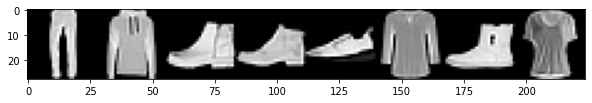

In [8]:
from torchvision import utils

dataiter = iter(train_loader)   
images, labels = next(dataiter)   

img   = utils.make_grid(images[:8], padding=0)
npimg = img.numpy()
plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(npimg, (1,2,0)))
plt.show()

In [20]:
len(fashion_trainset)

60000

In [21]:
len(train_loader)

600

batch_size 100개로 끊어서 60000개의 trainset이 600개로 묶임

#1st model

32->64->128->625,10으로 layer 형성

batch_size = 100

epoch = 20

learning_rate = 0.1 

In [26]:
class CNN(torch.nn.Module):

  def __init__(self):
    super(CNN, self).__init__()
    self.keep_prob = 0.5

    self.layer1 = torch.nn.Sequential(
        torch.nn.Conv2d(1, 32, kernel_size = 3, stride = 1, padding =1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size = 2, stride = 2)
    )
    self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
    
    self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding = 1))
    
    self.fc1 = torch.nn.Linear(4*4*128, 625, bias = True)
    torch.nn.init.xavier_uniform_(self.fc1.weight)
    self.layer4 = torch.nn.Sequential(
        self.fc1,
        torch.nn.ReLU(),
        torch.nn.Dropout(p=1-self.keep_prob)
    )
    self.fc2 = torch.nn.Linear(625, 10, bias = True)
    torch.nn.init.xavier_uniform_(self.fc2.weight)

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    out = out.view(out.size(0), -1)
    out = self.layer4(out)
    out = self.fc2(out)
    return out


In [28]:
model1 = CNN().to(device)

In [24]:
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model1.parameters(), lr=learning_rate)

In [29]:
training_model(model = model1, data = train_loader, epochs = training_epochs)

[Eporch:    1 cost = 2.30329347
[Eporch:    2 cost = 2.30334806
[Eporch:    3 cost = 2.30312824
[Eporch:    4 cost = 2.30272245
[Eporch:    5 cost = 2.30298615
[Eporch:    6 cost = 2.30301094
[Eporch:    7 cost = 2.30318809
[Eporch:    8 cost = 2.30347919
[Eporch:    9 cost = 2.30344534
[Eporch:   10 cost = 2.30274987
[Eporch:   11 cost = 2.30331492
[Eporch:   12 cost = 2.30273938
[Eporch:   13 cost = 2.3030684
[Eporch:   14 cost = 2.30292606
[Eporch:   15 cost = 2.30307579
[Eporch:   16 cost = 2.30317688
[Eporch:   17 cost = 2.30288339
[Eporch:   18 cost = 2.30288529
[Eporch:   19 cost = 2.3033812
[Eporch:   20 cost = 2.30225253


In [31]:
correct = 0

with torch.no_grad():
    for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model1(data)
            
            pred = output.max(1, keepdim=True)[1]
            # eq() 함수는 값이 일치하면 1을, 아니면 0을 출력.
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_accuracy = correct / len(test_loader.dataset)
    print('Accuracy:', test_accuracy)


Accuracy: 0.0932


너무 낮다...새로운 모델 제작

# 2 model

learning_rate=0.01로 조정
32->64->128->256->625->125로 레이어형성

In [33]:
learning_rate2 = 0.01

In [39]:
class CNN2(torch.nn.Module):

  def __init__(self):
    super(CNN2, self).__init__()
    self.keep_prob = 0.5

    self.layer1 = torch.nn.Sequential(
        torch.nn.Conv2d(1, 32, kernel_size = 3, stride = 1, padding =1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size = 2, stride = 2)
    )
    self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
    
    self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding = 1))
    
    self.layer4 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding = 1))
    
    self.fc1 = torch.nn.Linear(3*3*256, 625, bias = True)
    torch.nn.init.xavier_uniform_(self.fc1.weight)
    self.layer5 = torch.nn.Sequential(
        self.fc1,
        torch.nn.ReLU(),
        torch.nn.Dropout(p=1-self.keep_prob)
    )
    self.fc2 = torch.nn.Linear(625, 125, bias = True)
    self.layer6 = torch.nn.Sequential(
        self.fc2,
        torch.nn.ReLU(),
        torch.nn.Dropout(p=1-self.keep_prob)
    )
    torch.nn.init.xavier_uniform_(self.fc2.weight)
    self.fc3 = torch.nn.Linear(125,10, bias = True)
    torch.nn.init.xavier_uniform(self.fc3.weight)

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = out.view(out.size(0), -1)
    out = self.fc1(out)
    out = self.fc2(out)
    out = self.fc3(out)
    return out

In [40]:
model2 = CNN2().to(device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


In [41]:
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate2)

In [42]:
training_model(model = model2, data = train_loader, epochs = training_epochs)

[Eporch:    1 cost = 2.47744346
[Eporch:    2 cost = 2.30787635
[Eporch:    3 cost = 2.30745363
[Eporch:    4 cost = 2.30804706
[Eporch:    5 cost = 2.30811524
[Eporch:    6 cost = 2.30814624
[Eporch:    7 cost = 2.30773187
[Eporch:    8 cost = 2.30601954
[Eporch:    9 cost = 2.30613685
[Eporch:   10 cost = 2.30546951
[Eporch:   11 cost = 2.30490804
[Eporch:   12 cost = 2.30644369
[Eporch:   13 cost = 2.30721307
[Eporch:   14 cost = 2.30948377
[Eporch:   15 cost = 2.30637598
[Eporch:   16 cost = 2.3091619
[Eporch:   17 cost = 2.30771184
[Eporch:   18 cost = 2.30885959
[Eporch:   19 cost = 2.30888772
[Eporch:   20 cost = 2.30652857


In [43]:
correct = 0

with torch.no_grad():
    for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model2(data)
            
            pred = output.max(1, keepdim=True)[1]
            # eq() 함수는 값이 일치하면 1을, 아니면 0을 출력.
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_accuracy = correct / len(test_loader.dataset)
    print('Accuracy:', test_accuracy)


Accuracy: 0.1


그래도 성능이 쥐약이네...추가로 좀 모델을 가공해야한다.
https://docs.microsoft.com/ko-kr/windows/ai/windows-ml/tutorials/pytorch-train-model
batch_norm을 사용하여 데이터를 정규화해주는 작업을 추가하면 정확도가 증가한다고 한다. 이를 추가하여보자

# 3rd model

model2에 batch_norm 추가

In [44]:
class CNN3(torch.nn.Module):

  def __init__(self):
    super(CNN3, self).__init__()
    self.keep_prob = 0.5

    self.layer1 = torch.nn.Sequential(
        torch.nn.Conv2d(1, 32, kernel_size = 3, stride = 1, padding =1),
        torch.nn.BatchNorm2d(32),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size = 2, stride = 2)
    )
    self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
    
    self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding = 1))
    
    self.layer4 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding = 1))
    
    self.fc1 = torch.nn.Linear(3*3*256, 625, bias = True)
    torch.nn.init.xavier_uniform_(self.fc1.weight)
    self.layer5 = torch.nn.Sequential(
        self.fc1,
        torch.nn.ReLU(),
        torch.nn.Dropout(p=1-self.keep_prob)
    )
    self.fc2 = torch.nn.Linear(625, 125, bias = True)
    self.layer6 = torch.nn.Sequential(
        self.fc2,
        torch.nn.ReLU(),
        torch.nn.Dropout(p=1-self.keep_prob)
    )
    torch.nn.init.xavier_uniform_(self.fc2.weight)
    self.fc3 = torch.nn.Linear(125,10, bias = True)
    torch.nn.init.xavier_uniform(self.fc3.weight)

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = out.view(out.size(0), -1)
    out = self.fc1(out)
    out = self.fc2(out)
    out = self.fc3(out)
    return out

In [45]:
model3 = CNN3().to(device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


In [46]:
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model3.parameters(), lr=learning_rate2)

In [47]:
training_model(model = model3, data = train_loader, epochs = training_epochs)

[Eporch:    1 cost = 5.92335987
[Eporch:    2 cost = 0.455624461
[Eporch:    3 cost = 0.352664232
[Eporch:    4 cost = 0.311287254
[Eporch:    5 cost = 0.275258839
[Eporch:    6 cost = 0.251356274
[Eporch:    7 cost = 0.237576887
[Eporch:    8 cost = 0.225078836
[Eporch:    9 cost = 0.211476818
[Eporch:   10 cost = 0.207621306
[Eporch:   11 cost = 0.202663064
[Eporch:   12 cost = 0.198606297
[Eporch:   13 cost = 0.190399811
[Eporch:   14 cost = 0.18360126
[Eporch:   15 cost = 0.172340006
[Eporch:   16 cost = 0.182829574
[Eporch:   17 cost = 0.224106178
[Eporch:   18 cost = 0.169771239
[Eporch:   19 cost = 0.150145695
[Eporch:   20 cost = 0.149457589


In [48]:
correct = 0

with torch.no_grad():
    for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model3(data)
            
            pred = output.max(1, keepdim=True)[1]
            # eq() 함수는 값이 일치하면 1을, 아니면 0을 출력.
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_accuracy = correct / len(test_loader.dataset)
    print('Accuracy:', test_accuracy)

Accuracy: 0.9145


batch norm의 힘은 대단했다!!